# Introduction

This notebook supports the analysis of information about new particle formation events managed by the database. Events can be mapped, evaluated statistically, or described.

## Configuration

In [2]:
# Select the day and place
# Day format: yyyy-mm-dd
# Valid places: Hyytiälä, Värriö
# Examples: 
#  day = '2013-04-04', place = 'Hyytiälä'
#  day = '2013-04-08', place = 'Hyytiälä'
day = '2013-04-04'
place = 'Hyytiälä'

## Interpretation

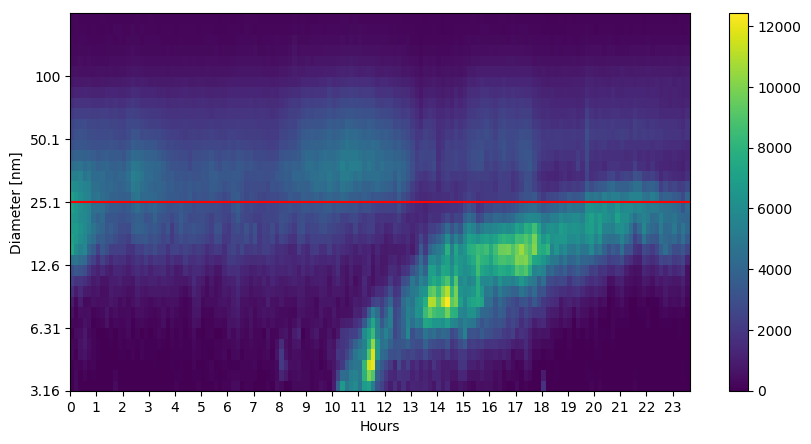

In [3]:
# Fetch and plot concentration data for the given day and place
# Data fetched from SmartSMEAR, https://avaa.tdata.fi/web/smart
plotdata(fetchdata(day, place))

In [4]:
# Configure information about the new particle formation event
# Time format: hh:mm, e.g. 11:00
# Valid classifications: Class Ia, Class Ib, Class II
# Examples:
#  For 2013-04-04, Hyytiälä: beginning='11:00', end='19:00', classification='Class Ia'
#  For 2015-03-10, Värriö: beginning='09:00', end='15:00', classification='Class Ib'
#  For 2016-10-02, Hyytiälä: beginning='11:00', end='17:00', classification='Class Ia'
#  For 2016-06-06, Hyytiälä: beginning='09:00', end='15:00', classification='Class Ia'
beginning = '11:00'
end = '19:00'
classification = 'Class Ia'

In [13]:
# Record information about the new particle formation event
record(event(day, place, beginning, end, classification), 'event1.n3')

## Initialization

In [12]:
import warnings
warnings.filterwarnings('ignore')
import requests, io, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from urllib.parse import urlencode
from datetime import datetime, timedelta
from pytz import timezone
from hashlib import md5
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, XSD, RDFS

configuration = {
    'Hyytiälä': {
        'smear_table': 'HYY_DMPS',
        'smear_variables': 'd316e1,d355e1,d398e1,d447e1,d501e1,d562e1,d631e1,d708e1,d794e1,'\
                           'd891e1,d100e2,d112e2,d126e2,d141e2,d158e2,d178e2,d200e2,d224e2,'\
                           'd251e2,d282e2,d316e2,d355e2,d398e2,d447e2,d501e2,d562e2,d631e2,'\
                           'd708e2,d794e2,d891e2,d100e3,d112e3,d126e3,d141e3,d158e3,d178e3,d200e3',
        'num_var_less_than_10nm': 10
    },
    'Puijo': {
        'smear_table': 'PUI_dmps_tot',
        'smear_variables': 'ch01,ch02,ch03,ch04,ch05,ch06,ch07,ch08,ch09,ch10,ch11,ch12,ch13,ch14,ch15,ch16,'\
                           'ch17,ch18,ch19,ch20,ch21,ch22,ch23,ch24,ch25,ch26,ch27,ch28,ch29,ch30,ch31,ch32,'\
                           'ch33,ch34,ch35,ch36,ch37,ch38,ch39,ch40',
        'num_var_less_than_10nm': 10
    },
    'Värriö': {
        'smear_table': 'VAR_DMPS',
        'smear_variables': 'd316e1,d355e1,d398e1,d447e1,d501e1,d562e1,d631e1,d708e1,d794e1,'\
                           'd891e1,d100e2,d112e2,d126e2,d141e2,d158e2,d178e2,d200e2,d224e2,'\
                           'd251e2,d282e2,d316e2,d355e2,d398e2,d447e2,d501e2,d562e2,d631e2,'\
                           'd708e2,d794e2,d891e2,d100e3,d112e3,d126e3,d141e3,d158e3,d178e3,d200e3',
        'num_var_less_than_10nm': 10
    }
}

ns = Namespace('http://avaa.tdata.fi/web/smart/smear/')
atPlace = URIRef('http://linkedevents.org/ontology/atPlace')
atTime = URIRef('http://linkedevents.org/ontology/atTime')
inSpace = URIRef('http://linkedevents.org/ontology/inSpace')
name = URIRef('http://www.geonames.org/ontology#name')
countryCode = URIRef('http://www.geonames.org/ontology#countryCode')
locationMap = URIRef('http://www.geonames.org/ontology#locationMap')
lat = URIRef('http://www.w3.org/2003/01/geo/wgs84_pos#lat')
long = URIRef('http://www.w3.org/2003/01/geo/wgs84_pos#long')
hasTime = URIRef('http://www.w3.org/2006/time#hasTime')
hasBeginning = URIRef('http://www.w3.org/2006/time#hasBeginning')
hasEnd = URIRef('http://www.w3.org/2006/time#hasEnd')
inXSDDateTime = URIRef('http://www.w3.org/2006/time#inXSDDateTime')
asWKT = URIRef('http://www.opengis.net/ont/geosparql#asWKT')
wktLiteral = URIRef('http://www.opengis.net/ont/geosparql#wktLiteral')
hasClassification = URIRef('http://avaa.tdata.fi/web/smart/smear/hasClassification')
ClassIa = URIRef('http://avaa.tdata.fi/web/smart/smear/ClassIa')
ClassIb = URIRef('http://avaa.tdata.fi/web/smart/smear/ClassIb')
ClassII = URIRef('http://avaa.tdata.fi/web/smart/smear/ClassII')


def fetchdata(date, place):
    time_from = timezone('Europe/Helsinki').localize(datetime.strptime(date, '%Y-%m-%d'))
    time_to = time_from + timedelta(days=1)

    try:
        smear_table = configuration[place]['smear_table']
        smear_variables = configuration[place]['smear_variables']
    except LookupError:
        print('Place not found in configuration [place = {}, places = {}]'.format(place, configuration.keys()))
        return list()

    query = {'table': smear_table, 'quality': 'ANY', 'averaging': 'NONE', 'type': 'NONE',
             'from': str(time_from), 'to': str(time_to), 'variables': smear_variables}
    url = 'http://avaa.tdata.fi/smear-services/smeardata.jsp?' + urlencode(query)
    response = requests.post(url)

    return pd.read_csv(io.StringIO(response.text))


def plotdata(data):
    d = data.copy(deep=True)
    d = d.ix[:, 6:].as_matrix()
    m = len(d)
    n = len(d[0])
    x = range(0, m)
    y = range(0, n)
    x, y = np.meshgrid(x, y)
    z = np.transpose(np.array([row[1:] for row in d]).astype(np.float))
    plt.figure(figsize=(10, 5), dpi=100)
    plt.pcolormesh(x, y, z)
    plt.plot((0, x.max()), (y.max()/2, y.max()/2), "r-")
    plt.colorbar()
    plt.xlim(xmax=m-1)
    x_ticks = np.arange(x.min(), x.max(), 6)
    x_labels = range(x_ticks.size)
    plt.xticks(x_ticks, x_labels)
    plt.xlabel('Hours')
    y_ticks = np.arange(y.min(), y.max(), 6)
    y_labels = ['3.16', '6.31', '12.6', '25.1', '50.1', '100']
    plt.yticks(y_ticks, y_labels)
    plt.ylabel('Diameter [nm]')
    plt.ylim(ymax=n-1)
    plt.show()


def record(entity, destination, format='n3'):
    entity.graph().serialize(destination=destination, format=format)
    
    
def places(place):
    return known_places[place]


def classes(label):
    return known_classes[label]

    
def event(date, place, beginning, end, classification):
    e = Event(date, places(place))
    e.set_time(beginning, end)
    e.set_classification(classes(classification))
    return e


class Entity:
    def __init__(self, identifier=None):
        self.identifier = None
        self.uri = None
        self.set_identifier(identifier)

    def set_identifier(self, identifier):
        if identifier is None:
            return

        if self.identifier is None:
            self.identifier = identifier
            self.uri = URIRef(self.identifier)
            return

        if self.identifier != identifier:
            raise ValueError('Incompatible identifiers {} {}'.format(self.identifier, identifier))

    def get_identifier(self):
        return self.identifier

    def get_uri(self):
        return self.uri
    
    
class Instant(Entity):
    def __init__(self, datetime):
        self.datetime = datetime
        self.iso_datetime = self.datetime.isoformat()
        self.literal_datetime = Literal(self.iso_datetime, datatype=XSD.dateTime)
        super().__init__('{}{}'.format(ns, md5(self.iso_datetime.encode()).hexdigest()))

    def get_datetime(self):
        return self.datetime

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://www.w3.org/2006/time#Instant')))
        g.add((self.uri, inXSDDateTime, self.literal_datetime))
        return g

    @staticmethod
    def from_date_time(date, time, tz=timezone('Europe/Helsinki')):
        return Instant(tz.localize(datetime.strptime('{} {}'.format(date, time), '%Y-%m-%d %H:%M')))

    

class Interval(Entity):
    def __init__(self, beginning, end):
        self.beginning = beginning
        self.end = end
        self.iso_interval = '{}/{}'.format(beginning.iso_datetime, end.iso_datetime)
        super().__init__('{}{}'.format(ns, md5(self.iso_interval.encode()).hexdigest()))

    def get_beginning(self):
        return self.beginning

    def get_end(self):
        return self.end

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://www.w3.org/2006/time#Interval')))
        g.add((self.uri, hasBeginning, self.beginning.uri))
        g.add((self.uri, hasEnd, self.end.uri))
        for s, p, o in self.beginning.graph():
            g.add((s, p, o))
        for s, p, o in self.end.graph():
            g.add((s, p, o))
        return g

    
class Point(Entity):
    def __init__(self, long, lat):
        self.point = 'POINT ({} {})'.format(long, lat)
        super().__init__('{}{}'.format(ns, md5(self.point.encode()).hexdigest()))

    def get_wkt(self):
        return self.point

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://www.opengis.net/ont/sf#Point')))
        g.add((self.uri, RDF.type, URIRef('http://www.w3.org/2003/01/geo/wgs84_pos#SpatialThing')))
        g.add((self.uri, asWKT, Literal(self.point, datatype=wktLiteral)))
        return g


class Event(Entity):
    def __init__(self, date=None, place=None):
        self.date = date
        self.place = place
        self.time = None
        self.geometry = None
        self.classification = None

        if date is not None and place is not None:
            super().__init__('{}{}'.format(ns,
                                           md5('{}{}'.format(self.date, self.place.name).encode()).hexdigest()))

        if place is not None:
            self.set_in_space(Point(place.get_longitude(), place.get_latitude()))

    def set_time(self, beginning, end):
        self.time = Interval(Instant.from_date_time(self.date, beginning), Instant.from_date_time(self.date, end))

    def set_at_time(self, beginning, end):
        self.time = Interval(beginning, end)

    def get_at_time(self):
        return self.time

    def get_at_place(self):
        return self.place

    def set_at_place(self, place):
        self.place = place
        self.set_in_space(Point(place.get_longitude(), place.get_latitude()))

    def get_in_space(self):
        return self.geometry

    def set_in_space(self, geometry):
        self.geometry = geometry

    def set_classification(self, classification):
        self.classification = classification

    def get_classification(self):
        return self.classification

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://linkedevents.org/ontology/Event')))
        g.add((self.uri, atPlace, self.place.uri))
        g.add((self.uri, inSpace, self.geometry.uri))
        g.add((self.uri, atTime, self.time.uri))
        g.add((self.uri, hasClassification, self.classification.uri))
        for s, p, o in self.place.graph():
            g.add((s, p, o))
        for s, p, o in self.geometry.graph():
            g.add((s, p, o))
        for s, p, o in self.time.graph():
            g.add((s, p, o))
        for s, p, o in self.classification.graph():
            g.add((s, p, o))
        return g


class Place(Entity):
    def __init__(self, identifier, name, country_code, location_map, latitude, longitude):
        super().__init__(identifier)
        self.name = name
        self.country_code = country_code
        self.location_map = location_map
        self.latitude = latitude
        self.longitude = longitude

    def get_name(self):
        return self.name

    def get_country_code(self):
        return self.country_code

    def get_location_map(self):
        return self.location_map

    def get_latitude(self):
        return self.latitude

    def get_longitude(self):
        return self.longitude

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#Place')))
        g.add((self.uri, RDF.type, URIRef('http://www.geonames.org/ontology#Feature')))
        g.add((self.uri, name, Literal(self.name, datatype=XSD.string)))
        g.add((self.uri, countryCode, Literal(self.country_code, datatype=XSD.string)))
        g.add((self.uri, locationMap, URIRef(self.location_map)))
        g.add((self.uri, lat, Literal(self.latitude)))
        g.add((self.uri, long, Literal(self.longitude)))
        return g
    

class Classification(Entity):
    def __init__(self, identifier, label, comment):
        super().__init__(identifier)
        self.label = label
        self.comment = comment

    def get_label(self):
        return self.label

    def get_comment(self):
        return self.comment

    def graph(self):
        g = Graph()
        g.add((self.uri, RDF.type, URIRef('http://avaa.tdata.fi/web/smart/smear/Classification')))
        g.add((self.uri, RDFS.label, Literal(self.label, datatype=XSD.string)))
        g.add((self.uri, RDFS.comment, Literal(self.comment, datatype=XSD.string)))
        return g
    
known_places = dict()
known_places['Hyytiälä'] = Place('http://sws.geonames.org/656888/', 'Hyytiälä', 'FI', 'http://www.geonames.org/656888/hyytiaelae.html', '61.84562', '24.29077')

known_classes = dict()
known_classes['Class Ia'] = Classification(ClassIa, 'Class Ia', 'Very clear and strong event')